### Import dependencies

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### import data

In [61]:
df = pd.read_csv("medical_examination.csv")

df.sample(n=5, random_state=26)

,id,age,sex,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
45357,64800,20420,2,171,72.0,140,80,1,1,0,0,1,1
23398,33427,23346,2,165,78.0,130,80,2,1,1,1,1,1
39769,56828,21214,1,155,70.0,120,80,1,1,0,0,0,1
47166,67365,16068,1,160,75.0,80,120,2,1,0,0,1,0
2961,4175,14378,1,167,67.0,110,80,1,1,0,0,1,0


### Add an overweight column to the data.
To determine if a person is overweight, first calculate their BMI by dividing their weight in kilograms by the square of their height in meters. If that value is > 25 then the person is overweight. Use the value 0 for NOT overweight and the value 1 for overweight.

In [62]:
bmi = df["weight"] / (df["height"] / 100) ** 2
df["overweight"] = (bmi > 25).astype(int)

### Normalize the data by making 0 always good and 1 always bad. 
If the value of cholesterol or gluc is 1, make the value 0. If the value is more than 1, make the value 1.

In [63]:
df[["cholesterol", "gluc"]] = (df[["cholesterol", "gluc"]] > 1).astype(int)

In [64]:
df.sample(n=5, random_state=26)

,id,age,sex,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,overweight
45357,64800,20420,2,171,72.0,140,80,0,0,0,0,1,1,0
23398,33427,23346,2,165,78.0,130,80,1,0,1,1,1,1,1
39769,56828,21214,1,155,70.0,120,80,0,0,0,0,0,1,1
47166,67365,16068,1,160,75.0,80,120,1,0,0,0,1,0,1
2961,4175,14378,1,167,67.0,110,80,0,0,0,0,1,0,0


### Convert data into long format and create a chart that shows the value counts of the categorical features using seaborn's `catplot()`.

The dataset should be split by 'Cardio' so there is one chart for each `cardio` value. The chart should look like

In [65]:
df_cat = pd.melt(df, id_vars=["cardio"], value_vars=["active", "alco", "cholesterol", "gluc", "overweight", "smoke"])
df_cat["total"] = 0
df_cat = df_cat.groupby(["cardio", "variable", "value"], as_index=False).count()
df_cat.sample(10)

,cardio,variable,value,total
18,1,gluc,0,28585
21,1,overweight,1,24440
16,1,cholesterol,0,23055
2,0,alco,0,33080
0,0,active,0,6378
11,0,smoke,1,3240
22,1,smoke,0,32050
8,0,overweight,0,15915
3,0,alco,1,1941
17,1,cholesterol,1,11924


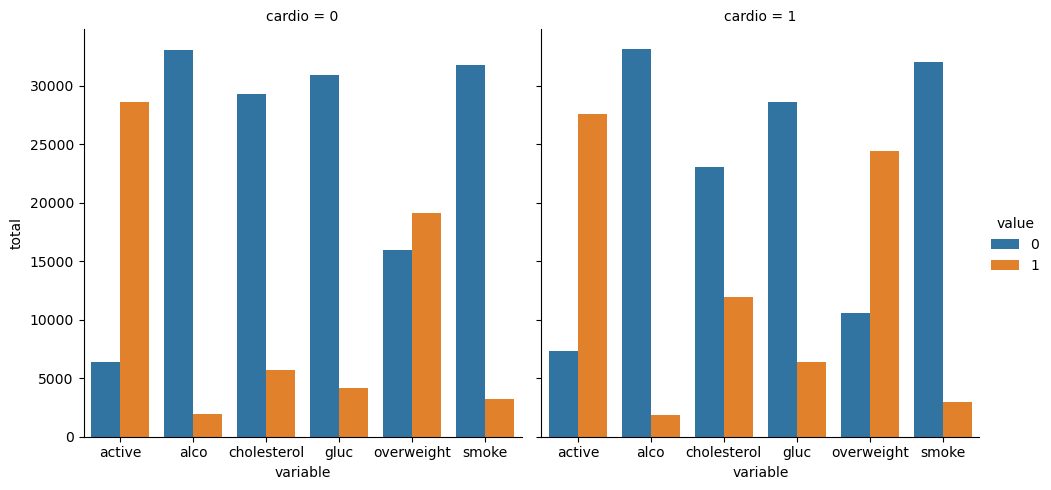

In [66]:
fig = sns.catplot(
    data=df_cat,
    x="variable",
    y="total",
    col="cardio",
    kind="bar",
    hue="value"
)

## Clean the data. Filter out the following patient segments that represent incorrect data:
diastolic pressure is higher than systolic (Keep the correct data with `(df['ap_lo'] <= df['ap_hi'])`)
height is less than the 2.5th percentile (Keep the correct data with `(df['height'] >= df['height']`.quantile(0.025))

1. height is more than the 97.5th percentile
2. weight is less than the 2.5th percentile
3. weight is more than the 97.5th percentile

In [67]:
df_heat = df[
    (df["ap_lo"] <= df["ap_hi"])
    & (df["height"] >= df["height"].quantile(0.025))
    & (df['weight'] <= df["weight"].quantile(0.975))
    & (df["weight"] >= df["weight"].quantile(0.025))
    & (df["weight"] <= df["weight"].quantile(0.975))
]
df_heat.shape

(64493, 14)

In [68]:
corr = df_heat.corr(method="pearson")
mask = np.triu(np.ones_like(corr, dtype=bool))
pd.DataFrame(corr)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,False,True,True,True,True,True,True,True,True,True,True,True,True,True
2,False,False,True,True,True,True,True,True,True,True,True,True,True,True
3,False,False,False,True,True,True,True,True,True,True,True,True,True,True
4,False,False,False,False,True,True,True,True,True,True,True,True,True,True
5,False,False,False,False,False,True,True,True,True,True,True,True,True,True
6,False,False,False,False,False,False,True,True,True,True,True,True,True,True
7,False,False,False,False,False,False,False,True,True,True,True,True,True,True
8,False,False,False,False,False,False,False,False,True,True,True,True,True,True
9,False,False,False,False,False,False,False,False,False,True,True,True,True,True


/home/kyoumas/anaconda3/envs/data-analysis/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

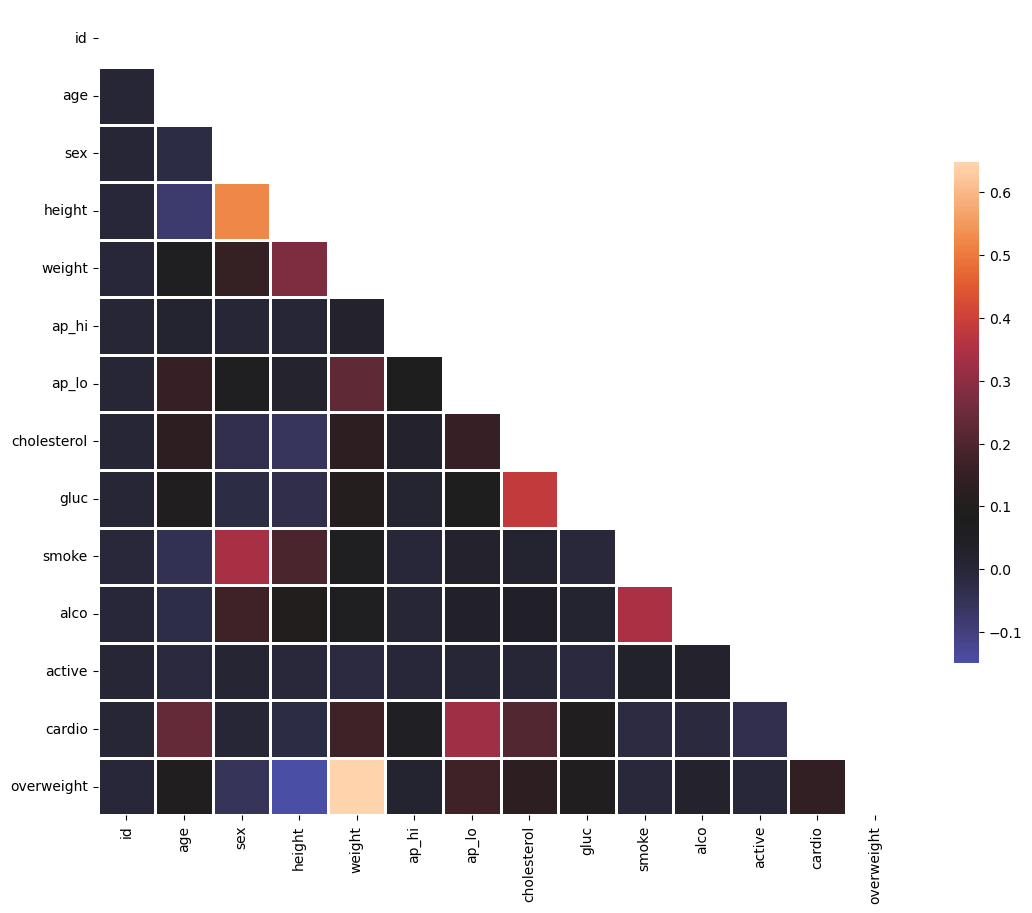

In [69]:
fig = plt.subplots(figsize=(13, 13))

sns.heatmap(
    corr,
    linewidths=1,
    annot=True,
    square=True,
    fmt=".1f",
    center=0.08,
    cbar_kws={"shrink": 0.5},
    mask=mask,
)